
# Domain Name Dataset Generation & Analysis

This notebook demonstrates how to use the `data_generator` module to create a synthetic dataset of business descriptions and domain name suggestions. It also computes simple metrics and visualises the distribution of generated confidence scores and domain lengths.


In [3]:
# Import our generator and analysis libraries
from data_generator import generate_dataset
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Enable inline plotting
%matplotlib inline


In [9]:
#@title Domain Dataset Generator (synthetic, seeded, policy-aware)
#@markdown Run this code to generate the JSONL dataset

import random
import json
from data_generator import generate_dataset

# Configuration parameters
num_records = 500  #@param {type:"integer"}  # total number of records to generate
blocked_prob = 0.1  #@param {type:"number"}  # fraction of descriptions that contain banned terms
low_score_chance = 0.3  #@param {type:"number"}  # chance of intentionally mismatching category for low scores
mission_prob = 0.3  #@param {type:"number"}  # chance of appending a mission statement in the description
target_prob = 0.3  #@param {type:"number"}  # chance of appending a target audience in the description
hyphen_prob = 0.2  #@param {type:"number"}  # chance of inserting a hyphen between concatenated keywords
num_suggestions = 10  #@param {type:"integer"}  # number of domain suggestions per record
output_file = "synthetic_domains.jsonl"  #@param {type:"string"}  # output filename (leave blank to skip saving)



In [10]:
# Seed the RNG for reproducibility
random.seed(18)

# Generate the dataset
dataset = generate_dataset(
    num_records,
    blocked_prob=blocked_prob,
    low_score_chance=low_score_chance,
    mission_prob=mission_prob,
    target_prob=target_prob,
    hyphen_prob=hyphen_prob,
    num_suggestions=num_suggestions,
)

# Optionally save to file
if output_file:
    with open(output_file, "w", encoding="utf-8") as f:
        for record in dataset:
            f.write(json.dumps(record, ensure_ascii=False) + "\n")
    print(f"Generated dataset with {len(dataset)} records and wrote to {output_file}")
else:
    print(f"Generated dataset with {len(dataset)} records (not saved to file)")
    # You can now work with the `dataset` list directly


Generated dataset with 500 records and wrote to synthetic_domains.jsonl


In [11]:
# Flatten the dataset into a DataFrame
rows = []
for rec in dataset:
    status = rec['output']['status']
    if status == 'success':
        for s in rec['output']['suggestions']:
            rows.append({
                'domain': s['domain'],
                'score': s['confidence'],
                'status': 'success',
                'keywords_used': ','.join(s.get('keywords_used', []))
            })
    else:
        # For blocked records, we record the status only
        rows.append({
            'domain': None,
            'score': None,
            'status': 'blocked',
            'keywords_used': ''
        })

# Create DataFrame
df = pd.DataFrame(rows)
print(df.head())
print("Total suggestions:", len(df))


                 domain  score   status keywords_used
0  breathesolutions.net   0.17  success       breathe
1         cloudzone.org   0.83  success         cloud
2     modeldeploy247.ai   0.73  success  model,deploy
3             jouip.org   0.23  success  journey,trip
4             bpute.org   0.93  success   bot,compute
Total suggestions: 2308


In [12]:
# Success vs blocked distribution
status_counts = df['status'].value_counts()
print("Status distribution:", status_counts)

# Filter successful suggestions
success_df = df[df['status'] == 'success'].copy()

# Basic statistics on confidence scores
score_stats = success_df['score'].describe()
print("Confidence score statistics:", score_stats)

# Length of domain names
success_df['length'] = success_df['domain'].str.len()
length_stats = success_df['length'].describe()
print("Domain length statistics:", length_stats)

# Correlation between length and score
corr = success_df[['score', 'length']].corr()
print("Correlation between score and domain length:", corr)

# Digit and hyphen prevalence
success_df['has_digit'] = success_df['domain'].str.contains(r'\d')
success_df['has_hyphen'] = success_df['domain'].str.contains('-')
print("Percentage of domains with digits:", success_df['has_digit'].mean() * 100)
print("Percentage of domains with hyphens:", success_df['has_hyphen'].mean() * 100)


Status distribution: status
success    2260
blocked      48
Name: count, dtype: int64
Confidence score statistics: count    2260.000000
mean        0.624774
std         0.322538
min         0.000000
25%         0.230000
50%         0.800000
75%         0.900000
max         1.000000
Name: score, dtype: float64
Domain length statistics: count    2260.000000
mean       15.202655
std         5.542990
min         6.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        49.000000
Name: length, dtype: float64
Correlation between score and domain length:            score    length
score   1.000000 -0.036622
length -0.036622  1.000000
Percentage of domains with digits: 24.867256637168143
Percentage of domains with hyphens: 3.5840707964601775


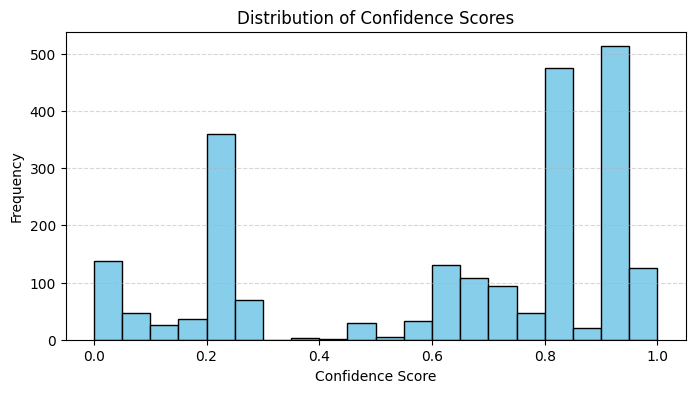

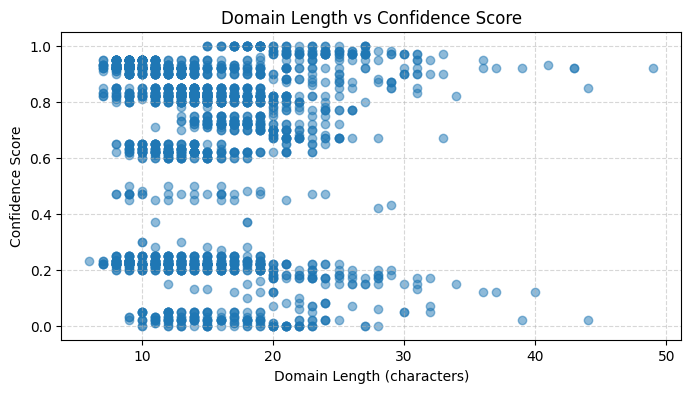

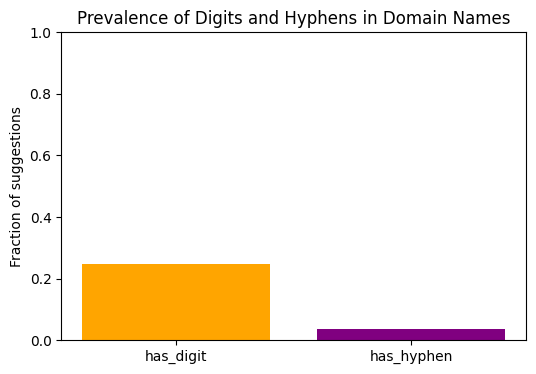

In [13]:
# Histogram of confidence scores
plt.figure(figsize=(8, 4))
plt.hist(success_df['score'], bins=np.linspace(0, 1, 21), color='skyblue', edgecolor='black')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Scatter plot of domain length vs. score
plt.figure(figsize=(8, 4))
plt.scatter(success_df['length'], success_df['score'], alpha=0.5)
plt.title('Domain Length vs Confidence Score')
plt.xlabel('Domain Length (characters)')
plt.ylabel('Confidence Score')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Bar chart: frequency of digits and hyphens
plt.figure(figsize=(6, 4))
features = ['has_digit', 'has_hyphen']
values = [success_df['has_digit'].mean(), success_df['has_hyphen'].mean()]
plt.bar(features, values, color=['orange', 'purple'])
plt.title('Prevalence of Digits and Hyphens in Domain Names')
plt.ylabel('Fraction of suggestions')
plt.ylim(0, 1)
plt.show()
